In [ ]:
%cd /ai-adulteration-detection

In [ ]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
train_data_path = "./npz_files/shuffled_train_arr_MFCCs.npz"
train_data = np.load(train_data_path, allow_pickle = True)
arr_0_train = train_data['arr_0']
arr_1_train = train_data['arr_1']
print(arr_0_train.shape, arr_1_train.shape)

valid_data_path = "./npz_files/shuffled_valid_arr_MFCCs.npz"
valid_data = np.load(valid_data_path, allow_pickle = True)
arr_0_valid = valid_data['arr_0']
arr_1_valid = valid_data['arr_1']
print(arr_0_valid.shape, arr_1_valid.shape)

X = np.concatenate((arr_0_train, arr_0_valid))
y = np.concatenate((arr_1_train, arr_1_valid))
print(X.shape, y.shape) 

(8010, 173, 40) (8010,)
(1001, 173, 40) (1001,)
(9011, 173, 40) (9011,)


In [ ]:
np.unique(y, return_counts = True)

(array([0, 1, 2, 3]), array([2222, 2271, 2266, 2252]))

### CRNN MODEL

In [ ]:
def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        
        layer = Conv1D(
                filters = CONV_FILTER_COUNT,
                kernel_size = FILTER_LENGTH,
                kernel_regularizer = regularizers.l2(L2_regularization),
                name='convolution_' + str(i + 1))(layer)
        layer = BatchNormalization(momentum = 0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ### LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences = False)(layer)
    layer = Dropout(0.4)(layer)
    
    ### Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer = regularizers.l2(L2_regularization), name = 'dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ### Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name = 'output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    opt = Adam(lr=0.001)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
    
    # print(model.summary())
    return model

In [ ]:
def train_model(x_train, y_train, x_val, y_val, fold_num):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name = 'input')
    
    model = conv_recurrent_model_build(model_input)

    model_filepath = "./models/CRNN_MFCCs_withCV_" + str(fold_num) + "_model.h5"
    checkpoint_callback = ModelCheckpoint(filepath = model_filepath, monitor = 'val_accuracy', verbose = 1,
                                          save_best_only = True, mode = 'max')
    
    reducelr_callback = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 10, min_delta = 0.01, verbose = 1)
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history
    print('Training...')
    history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCH_COUNT,
                        validation_data = (x_val, y_val), verbose = 2, callbacks = callbacks_list)
    # verbose: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

    return model, history

### TRAINING WITH CROSS-VALIDATION

In [ ]:
# num_classes = np.amax(y) + 1
# n_features = X.shape[2]
# n_time = X.shape[1]

# N_LAYERS = 3
# FILTER_LENGTH = 5
# CONV_FILTER_COUNT = 56
# BATCH_SIZE = 64
# LSTM_COUNT = 96
# EPOCH_COUNT = 50
# NUM_HIDDEN = 64
# L2_regularization = 0.001

# from keras.utils import to_categorical
# from sklearn.model_selection import StratifiedKFold
# from datetime import datetime

# # K = 5
# skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 15)

# train_accuracy_arr = np.empty((0, EPOCH_COUNT))
# train_loss_arr = np.empty((0, EPOCH_COUNT))
# valid_accuracy_arr = np.empty((0, EPOCH_COUNT))
# valid_loss_arr = np.empty((0, EPOCH_COUNT))

# training_times = np.empty((0))

# fold_count = 0

# for train_index, valid_index in skf.split(X, y):
  
#   start = datetime.now()

#   fold_count += 1
#   print("Training on fold:", fold_count)
  
#   X_train = X[train_index]
#   X_valid = X[valid_index]
#   y_train = to_categorical(y[train_index], num_classes = 4)
#   y_valid = to_categorical(y[valid_index], num_classes = 4)
  
#   model, history  = train_model(X_train, y_train, X_valid, y_valid, fold_count) 
  
#   train_accuracy_arr = np.append(train_accuracy_arr, [history.history['accuracy']], axis = 0)
#   train_loss_arr = np.append(train_loss_arr, [history.history['loss']], axis = 0)
#   valid_accuracy_arr = np.append(valid_accuracy_arr, [history.history['val_accuracy']], axis = 0)
#   valid_loss_arr = np.append(valid_loss_arr, [history.history['val_loss']], axis = 0)

#   duration = datetime.now() - start
#   print("Training completed in time:", duration)

#   training_times = np.append(training_times, [duration])
  
#   score = model.evaluate(X_valid, y_valid, verbose = 1)
#   accuracy = 100 * score[1]
#   print("Training accuracy for validation data: %.4f%%" %accuracy)

# %cd ./npz_files_results
# np.savez("training_times_MFCCs", training_times)
# np.savez("train_accuracy_arr_MFCCs", train_accuracy_arr)
# np.savez("train_loss_arr_MFCCs", train_loss_arr)
# np.savez("valid_accuracy_arr_MFCCs", valid_accuracy_arr)
# np.savez("valid_loss_arr_MFCCs", valid_loss_arr)
# %cd /ai-adulteration-detection

Training on fold: 1
Building model...
Training...
Train on 7208 samples, validate on 1803 samples
Epoch 1/50
 - 13s - loss: 0.3441 - accuracy: 0.9599 - val_loss: 0.2243 - val_accuracy: 0.9928

Epoch 00001: val_accuracy improved from -inf to 0.99279, saving model to /content/drive/My Drive/Data Science Projects/Peynir/Peynir-Paper/models/CRNN_MFCCs_withCV_1_model.h5
Epoch 2/50
 - 5s - loss: 0.2061 - accuracy: 0.9964 - val_loss: 0.1762 - val_accuracy: 1.0000

Epoch 00002: val_accuracy improved from 0.99279 to 1.00000, saving model to /content/drive/My Drive/Data Science Projects/Peynir/Peynir-Paper/models/CRNN_MFCCs_withCV_1_model.h5
Epoch 3/50
 - 5s - loss: 0.1628 - accuracy: 0.9993 - val_loss: 0.1437 - val_accuracy: 1.0000

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/50
 - 5s - loss: 0.1389 - accuracy: 0.9976 - val_loss: 0.1195 - val_accuracy: 1.0000

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/50
 - 5s - loss: 0.1147 - accuracy: 0.9981 - val_loss:

### RESULTS

In [ ]:
# %cd ./npz_files_results
# train_accuracy = np.load("train_accuracy_arr_MFCCs.npz", allow_pickle = True)
# train_accuracy_arr = train_accuracy['arr_0']
# train_loss = np.load("train_loss_arr_MFCCs.npz", allow_pickle = True)
# train_loss_arr = train_loss['arr_0']
# valid_accuracy = np.load("valid_accuracy_arr_MFCCs.npz", allow_pickle = True)
# valid_accuracy_arr = valid_accuracy['arr_0']
# valid_loss = np.load("valid_loss_arr_MFCCs.npz", allow_pickle = True)
# valid_loss_arr = valid_loss['arr_0']
# %cd /ai-adulteration-detection
# EPOCH_COUNT = 50

In [ ]:
train_accuracy_mean = np.mean(train_accuracy_arr, axis = 0)
train_accuracy_std = np.std(train_accuracy_arr, axis = 0)
valid_accuracy_mean = np.mean(valid_accuracy_arr, axis = 0)
valid_accuracy_std = np.std(valid_accuracy_arr, axis = 0)

train_loss_mean = np.mean(train_loss_arr, axis = 0)
train_loss_std = np.std(train_loss_arr, axis = 0)
valid_loss_mean = np.mean(valid_loss_arr, axis = 0)
valid_loss_std = np.std(valid_loss_arr, axis = 0) 

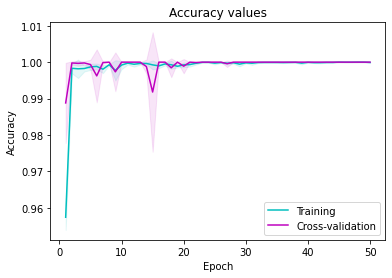

In [ ]:
# Plot accuracy curve
epochs = np.linspace(1, EPOCH_COUNT, EPOCH_COUNT)

plt.fill_between(epochs, train_accuracy_mean - train_accuracy_std,
                 train_accuracy_mean + train_accuracy_std, alpha = 0.1,
                 color = "c")
plt.fill_between(epochs, valid_accuracy_mean - valid_accuracy_std,
                 valid_accuracy_mean + valid_accuracy_std, alpha = 0.1,
                 color = "m")
   
plt.plot(epochs, train_accuracy_mean, color = "c",
         label = "Training")
plt.plot(epochs, valid_accuracy_mean, color = "m",
         label = "Cross-validation")

plt.title('Accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.show()

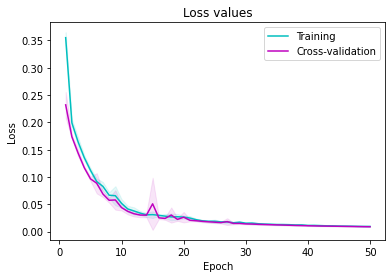

In [ ]:
# Plot loss curve
epochs = np.linspace(1, EPOCH_COUNT, EPOCH_COUNT)

plt.fill_between(epochs, train_loss_mean - train_loss_std,
                 train_loss_mean + train_loss_std, alpha = 0.1,
                 color = "c")
plt.fill_between(epochs, valid_loss_mean - valid_loss_std,
                 valid_loss_mean + valid_loss_std, alpha = 0.1,
                 color = "m")
   
plt.plot(epochs, train_loss_mean, color = "c",
         label = "Training")
plt.plot(epochs, valid_loss_mean, color = "m",
         label = "Cross-validation")

plt.title('Loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### TEST THE MODEL

In [ ]:
# Compile the model
num_classes = np.amax(y) + 1
n_features = X.shape[2]
n_time = X.shape[1]

N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 64
LSTM_COUNT = 96
EPOCH_COUNT = 50
NUM_HIDDEN = 64
L2_regularization = 0.001

n_features = X.shape[2]
input_shape = (None, n_features)
model_input = Input(input_shape, name = 'input')

model = conv_recurrent_model_build(model_input)

model.load_weights("./models/CRNN_MFCCs_withCV_1_model.h5") # select which model will be used

Building model...


In [ ]:
test_data_path = "./npz_files/shuffled_test_arr_MFCCs.npz"
test_data = np.load(test_data_path, allow_pickle = True)
arr_0_test = test_data['arr_0']
arr_1_test = test_data['arr_1']

X_test = arr_0_test
print(X_test.shape) 
from keras.utils import to_categorical
y_test = to_categorical(arr_1_test, num_classes = 4)
print(y_test.shape)

(1002, 173, 40)
(1002, 4)


In [ ]:
np.unique(arr_1_test, return_counts = True)

(array([0, 1, 2, 3]), array([268, 236, 243, 255]))

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 1)
accuracy = 100 * score[1]
print("Training accuracy for test data: %.4f%%" %accuracy)

1002/1002 [==============================] - 0s 352us/step
Training accuracy for test data: 100.0000%


In [ ]:
dict_classes = {"Cheese":0, "Empty":1, "NonorganicButter":2, "OrganicButter":3}

y_true = np.argmax(y_test, axis = 1)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

target_names = dict_classes.keys()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))

                  precision    recall  f1-score   support

          Cheese       1.00      1.00      1.00       268
           Empty       1.00      1.00      1.00       236
NonorganicButter       1.00      1.00      1.00       243
   OrganicButter       1.00      1.00      1.00       255

        accuracy                           1.00      1002
       macro avg       1.00      1.00      1.00      1002
    weighted avg       1.00      1.00      1.00      1002

[[268   0   0   0]
 [  0 236   0   0]
 [  0   0 243   0]
 [  0   0   0 255]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


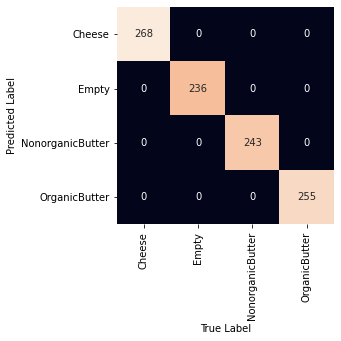

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False,
            xticklabels = dict_classes.keys(),
            yticklabels = dict_classes.keys())
plt.xlabel('True Label')
plt.ylabel('Predicted Label');